# P2P Lending Profit (in R)
<i> Authors: Markus Viljanen </i>

In this notebook, we give an R version of the regression models. See the Python notebook 'P2P Lending Models Python.ipynb' for a thorough tutorial. There are two reasons why the R version might be used:

1. Interpretation: The Tikhonov regularization can increase predictive accuracy but introduces a small bias to the coefficients.
2. Log-link: if one wishes to restrict the recovery rates to be positive, one can use the log-link not available in scikit-learn.

The R model therefore implements an exact version of the previous model formulations for the default rate and recovery rate:

$$ \frac{P(Y_{i,t} = 1)}{1 - P(Y_{i,t} = 1)} = \text{exp}(\alpha^T e_t + \beta^T x_i) $$ 

$$ E[Y_{i,t}] = \text{exp}(\alpha^T e_t + \beta^T x_i) $$ 



In [11]:
options(repr.plot.width=4, repr.plot.height=3)

## Imports

In [16]:
require(biglm)
require(caret)
require(ROCR)

Loading required package: ROCR
Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



In [41]:
source("utilities.R")

## Load Data

We load the same data set as in the Python tutorial:

In [2]:
df_loan = read.table('datas/LoanData2.csv', sep=',', header=T, stringsAsFactors=T)
df_loan <- subset(df_loan, (df_loan$Year > 2009))

The numeric columns are processed into quantiles, and categorical columns into contrast coded factors where the baseline is the most common category. 

In [3]:
col_numeric = c('Age', 'ApplicationSignedHour', 'ApplicationSignedWeekday', 'LoanDuration', 'Amount',
                'IncomeTotal', 'LiabilitiesTotal', 'LiabilitiesToIncome', 'LoansToIncome', 'PaymentToIncome',
                'ExistingLiabilities', 'PreviousNumber_Intervals', 'PreviousNumber', 'PreviousNumber_Current',
                'PreviousNumber_Default', 'PreviousNumber_Repaid', 'PreviousNumber_Rescheduled')
for (col in col_numeric) {
  df_loan[[col]] <- rank(df_loan[[col]]) / length(df_loan[[col]])
}

col_classes = c('Year', 'Rating', 'Rating2', 'Gender', 'Education', 'HomeOwnershipType',
                'EmploymentDurationCurrentEmployer', 'VerificationType', 'LiabilitiesToIncomeUnknown', 'NoHistory')
for (col in col_classes) {
  ref <- names(which.max(table(df_loan[[col]])))
  df_loan[[col]] <- factor(df_loan[[col]])
  contrasts(df_loan[[col]]) <- contr.treatment(levels(df_loan[[col]]), base=which(levels(df_loan[[col]])==ref))
}

This data set describes the loan features:

In [4]:
head(df_loan)

LoanId,Interest,Year,Rating,Rating2,Gender,Age,Education,HomeOwnershipType,ApplicationSignedHour,...,LoansToIncome,PaymentToIncome,ExistingLiabilities,PreviousNumber_Intervals,NoHistory,PreviousNumber,PreviousNumber_Current,PreviousNumber_Default,PreviousNumber_Repaid,PreviousNumber_Rescheduled
66AE108B-532B-4BB3-BAB7-0019A46412C1,20.97,2016,C,EE:1000.0,Female,0.8116931,Secondary education,Owner,0.6962071,...,0.5944602,0.8836594,0.9138590,0.8182927,False,0.5838987,0.6403428,0.4962192,0.4207,0.4445547
D152382E-A50D-46ED-8FF2-0053E0C86A70,17.12,2015,B,EE:1000.0,Female,0.7538277,Higher education,Owner,0.2576790,...,0.6471470,0.6215225,0.7168541,0.6798504,False,0.5838987,0.6403428,0.4962192,0.4207,0.4445547
87342E13-66CB-483F-833A-007953E50C78,13.67,2016,A,EE:1000.0,Male,0.6178322,Secondary education,Mortgage,0.9103530,...,0.2420294,0.9020138,0.8841655,0.2479085,True,0.2420797,0.2687063,0.4962192,0.4207,0.4445547
87227056-6BF9-410C-98D1-008F788E122A,40.40,2015,F,ES:B,Male,0.5650214,Basic education,Living with parents,0.5638851,...,0.2420294,0.5307058,0.2984032,0.2479085,True,0.2420797,0.2687063,0.4962192,0.4207,0.4445547
2DDE6336-E466-4624-A337-00A0ED1A1468,68.39,2015,HR,ES:C,Female,0.3390537,Secondary education,Tenant,0.8449897,...,0.2420294,0.6861853,0.7899634,0.2479085,True,0.2420797,0.2687063,0.4962192,0.4207,0.4445547
BA1FC89D-44B5-4481-9FCD-00C4BBC174B0,73.73,2015,HR,ES:C,Female,0.2516960,Secondary education,Tenant,0.9535978,...,0.2420294,0.4036628,0.7899634,0.2479085,True,0.2420797,0.2687063,0.4962192,0.4207,0.9263411


The df_Y dataframe describes the monthly default events:

In [5]:
df_Y = read.table('datas/df_Y.csv', sep=',', header=T, stringsAsFactors=T)
df_Y <- subset(df_Y, (df_Y$T <= 60))
df_Y$T <- factor(df_Y$T)
head(df_Y)

LoanId,T,Y
66AE108B-532B-4BB3-BAB7-0019A46412C1,1,0
66AE108B-532B-4BB3-BAB7-0019A46412C1,2,0
66AE108B-532B-4BB3-BAB7-0019A46412C1,3,0
66AE108B-532B-4BB3-BAB7-0019A46412C1,4,0
66AE108B-532B-4BB3-BAB7-0019A46412C1,5,0
66AE108B-532B-4BB3-BAB7-0019A46412C1,6,0


The df_R dataframe describes the monthly recoveries:

In [65]:
df_R = read.table('datas/df_R.csv', sep=',', header=T)
df_R <- subset(df_R, (df_R$T <= 60))
df_R$T <- factor(df_R$T)
head(df_R)

LoanId,T,Y
66AE108B-532B-4BB3-BAB7-0019A46412C1,1,0.00000000
66AE108B-532B-4BB3-BAB7-0019A46412C1,2,0.00000000
66AE108B-532B-4BB3-BAB7-0019A46412C1,3,0.00000000
66AE108B-532B-4BB3-BAB7-0019A46412C1,4,0.04660618
66AE108B-532B-4BB3-BAB7-0019A46412C1,5,0.00000000
66AE108B-532B-4BB3-BAB7-0019A46412C1,6,0.00000000


## Default model

We first combine the dataframes to attach features to each default event:

In [6]:
df <- merge(df_loan, df_Y)

The overall default rate in the data set sees to be highest in the first month and then decreases as the loan survives:

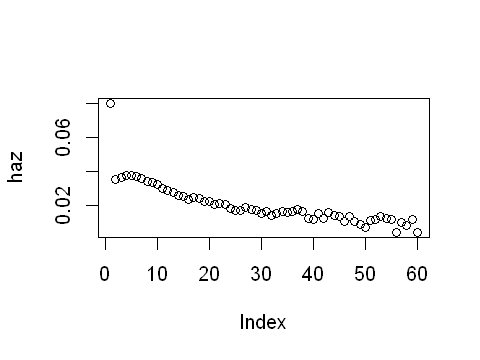

In [12]:
haz <- table(df$Y, df$T)
haz <- haz[2,]/(haz[1,]+haz[2,])
plot(haz)

The overall default rate also depends on the credit rating, as is to be expected:

In [13]:
haz <- table(df$Y, df$Rating)
haz <- haz[2,]/(haz[1,]+haz[2,])
round(haz*100,2)

-    A    B    C    D    E    F   HR 
2.37 1.14 1.53 2.00 2.94 3.77 7.37 9.32

Lets try some models.

The simplest model uses only Bondora credit rating to predict the defaults:

In [17]:
formula1 <- Y~T-1+Rating
fit <- bigglm(formula1, data=df, family=binomial(link='logit'), chunksize=100000, maxint=1000)
P <- as.vector(predict(fit, df, type="response"))
auc.tmp <- performance(prediction(P, df$Y),"auc")
print(auc.tmp@y.values[[1]])

[1] 0.7023972


Pretty good. But lets see if we can drop the Bondora credit rating and develop a better model.

The following model uses only borrower features:

In [18]:
formula2 <- Y~T-1+Rating2+Gender+Age+Education+HomeOwnershipType+ApplicationSignedHour+ApplicationSignedWeekday+EmploymentDurationCurrentEmployer
fit <- bigglm(formula2, data=df, family=binomial(link='logit'), chunksize=100000, maxint=1000)
P <- as.vector(predict(fit, df, type="response"))
auc.tmp <- performance(prediction(P, df$Y),"auc")
print(auc.tmp@y.values[[1]])

Warning message in bigglm.function(formula = formula, data = datafun, ...):
"ran out of iterations and failed to converge"

[1] 0.7151727


The second model uses only loan features:

In [19]:
formula3 <- Y~T-1+Year+LoanDuration+Amount+VerificationType+IncomeTotal+LiabilitiesTotal+LiabilitiesToIncome+LiabilitiesToIncomeUnknown+LoansToIncome+PaymentToIncome+ExistingLiabilities
fit <- bigglm(formula3, data=df, family=binomial(link='logit'), chunksize=100000, maxint=1000)
P <- as.vector(predict(fit, df, type="response"))
auc.tmp <- performance(prediction(P, df$Y),"auc")
print(auc.tmp@y.values[[1]])

Warning message in bigglm.function(formula = formula, data = datafun, ...):
"ran out of iterations and failed to converge"

[1] 0.6823929


The third model uses only the information of past lending history in the Bondora platform (so useless for new customers):

In [20]:
formula4 <- Y~T-1+PreviousNumber_Intervals+NoHistory+PreviousNumber+PreviousNumber_Current+PreviousNumber_Default+PreviousNumber_Repaid+PreviousNumber_Rescheduled
fit <- bigglm(formula4, data=df, family=binomial(link='logit'), chunksize=100000, maxint=1000)
P <- as.vector(predict(fit, df, type="response"))
auc.tmp <- performance(prediction(P, df$Y),"auc")
print(auc.tmp@y.values[[1]])

Warning message in bigglm.function(formula = formula, data = datafun, ...):
"ran out of iterations and failed to converge"

[1] 0.6550988


Lets put all three sources of information (borrower, loan, past loans) together and develop a full model:

In [21]:
formula <- Y~T-1+Year+Rating2+Gender+Age+Education+HomeOwnershipType+ApplicationSignedHour+ApplicationSignedWeekday+EmploymentDurationCurrentEmployer+LoanDuration+Amount+VerificationType+IncomeTotal+LiabilitiesTotal+LiabilitiesToIncome+LiabilitiesToIncomeUnknown+LoansToIncome+PaymentToIncome+ExistingLiabilities+PreviousNumber_Intervals+NoHistory+PreviousNumber+PreviousNumber_Current+PreviousNumber_Default+PreviousNumber_Repaid+PreviousNumber_Rescheduled
fit <- bigglm(formula, data=df, family=binomial(link='logit'), chunksize=100000, maxint=1000)
P <- as.vector(predict(fit, df, type="response"))
auc.tmp <- performance(prediction(P, df$Y),"auc")
print(auc.tmp@y.values[[1]])

Warning message in bigglm.function(formula = formula, data = datafun, ...):
"ran out of iterations and failed to converge"

[1] 0.7341629


Not bad!

Now that we have a model we can predict the credit risk. Since month is simply an intercept term (T-1), we can predict the log-odds of default probability in the first month to obtain the relative credit risk in each loan:

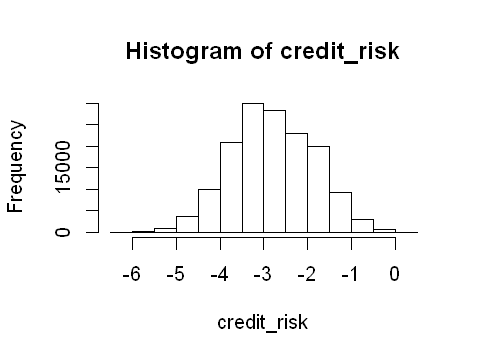

In [48]:
df_X <- df_loan[c('LoanId')]
df_X$Y <- 0
df_X$T <- factor(rep(1, nrow(df_X)), levels=levels(df_Y$T))
df_test <- merge(df_X, df_loan)
credit_risk <- as.vector(predict(fit, df_test))
hist(credit_risk)

The effect of different features can be interpreted from the coefficients, though there are quite many:

In [29]:
coefs = summary(fit)$mat
coefs[61:nrow(coefs),]

,Coef,(95%,CI),SE,p
Year2010,0.66910808,0.53881694,0.79939922,0.06514557,9.524411e-25
Year2011,0.37432705,0.17964282,0.56901128,0.09734211,1.203172e-04
Year2012,0.04414352,-0.17575213,0.26403917,0.10994783,6.880556e-01
Year2013,0.16207878,0.07895227,0.24520528,0.04156325,9.636400e-05
Year2014,0.14089611,0.08658820,0.19520403,0.02715396,2.116676e-07
Year2015,0.29669582,0.24537037,0.34802127,0.02566273,6.468175e-31
Year2016,0.62126526,0.57624903,0.66628149,0.02250812,1.057747e-167
Year2017,0.70189737,0.66869557,0.73509917,0.01660090,0.000000e+00
Year2018,0.42346513,0.39417497,0.45275529,0.01464508,7.694909e-184
Year2020,-0.84371612,-0.90605942,-0.78137282,0.03117165,2.424300e-161


There is an accessory function I wrote to visualize the results

In [30]:
coef <- add_label(fit)
coef <- add_levels(df, coef)
coef.list <- split(coef, coef$Term)

For example, the effect of 'Year' is quite interesting, where some years had almost double the odds of default:

Warning message:
"Removed 1 rows containing missing values (geom_errorbar)."

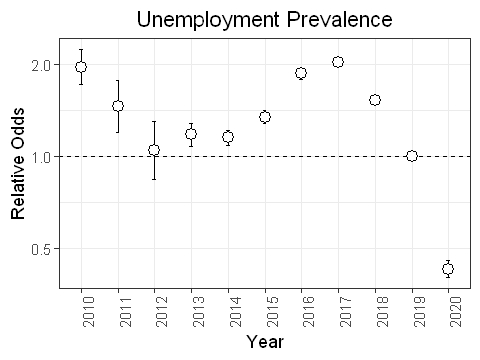

In [42]:
plot_oddsratio(coef.list[['Year']])

For example, 'Rating2' combines countries and their specific credit rating system into a 'Country':'Credit Rating' feature. It looks like some countries are a lot riskier, and the credit rating has a smaller but significant effect:

Warning message:
"Removed 1 rows containing missing values (geom_errorbar)."

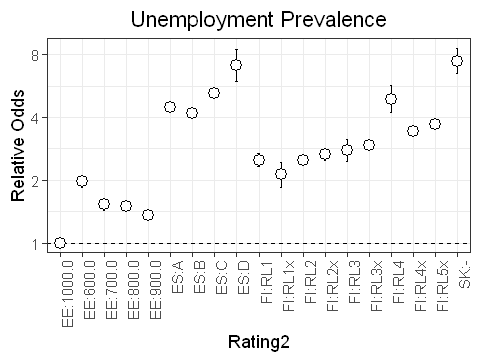

In [43]:
plot_oddsratio(coef.list[['Rating2']])

## Loss Given Default model

In the second model we combine the dataframes to attach features to each recovery:

In [50]:
df <- merge(df_loan, df_R)

It looks like the mean recovery in the data set approaches zero over time almost linearly:

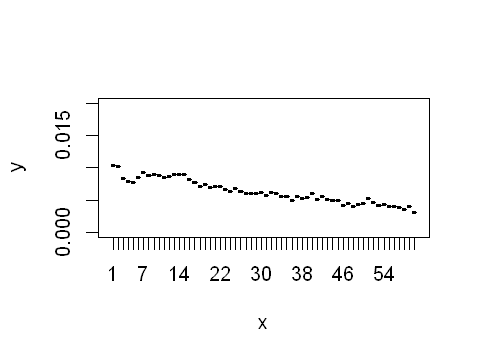

In [51]:
dc <- aggregate(Y ~T, df, mean)
plot(dc$T, dc$Y, ylim=c(0.00, 0.02))

By a quick analysis the mean recovery also depends on the credit rating, with higher risk loans recovering less principal:

In [54]:
lgd <- aggregate(Y ~ Rating, df, mean)
lgd

Rating,Y
-,0.018831359
A,0.009803446
B,0.008917001
C,0.008868636
D,0.008594854
E,0.007985837
F,0.006654166
HR,0.005886286


Lets try some models.

The simplest model uses only Bondora credit rating to predict the defaults:

In [55]:
formula1 <- Y~T-1+Rating
fit <- bigglm(formula1, data=df, family=gaussian(link='log'), chunksize=100000, maxint=1000)
r <- as.vector(predict(fit, df, type="response"))
mean((df$Y - r)**2)

Warning message in bigglm.function(formula = formula, data = datafun, ...):
"ran out of iterations and failed to converge"

[1] 0.002987417

Lets again see if we can drop the Bondora credit rating and develop a better model.

The following model uses only borrower features:


In [56]:
formula2 <- Y~T-1+Rating2+Gender+Age+Education+HomeOwnershipType+ApplicationSignedHour+ApplicationSignedWeekday+EmploymentDurationCurrentEmployer
fit <- bigglm(formula2, data=df, family=gaussian(link='identity'), chunksize=100000, maxint=1000)
r <- as.vector(predict(fit, df, type="response"))
mean((df$Y - r)**2)

[1] 0.002981015

The second model uses only loan features:


In [57]:
formula3 <- Y~T-1+Year+LoanDuration+Amount+VerificationType+IncomeTotal+LiabilitiesTotal+LiabilitiesToIncome+LiabilitiesToIncomeUnknown+LoansToIncome+PaymentToIncome+ExistingLiabilities#+LiabilitiesToIncomeUnknown
fit <- bigglm(formula3, data=df, family=gaussian(link='identity'), chunksize=100000, maxint=1000)
r <- as.vector(predict(fit, df, type="response"))
mean((df$Y - r)**2)

[1] 0.002982808

The third model uses only the information of past lending history in the Bondora platform (so useless for new customers):


In [58]:
formula4 <- Y~T-1+PreviousNumber_Intervals+NoHistory+PreviousNumber+PreviousNumber_Current+PreviousNumber_Default+PreviousNumber_Repaid+PreviousNumber_Rescheduled
fit <- bigglm(formula4, data=df, family=gaussian(link='identity'), chunksize=100000, maxint=1000)
r <- as.vector(predict(fit, df, type="response"))
mean((df$Y - r)**2)

[1] 0.002989698


Lets put all three sources of information (borrower, loan, past loans) together and develop a full model:


In [59]:
formula <- Y~T-1+Year+Rating+Rating2+Gender+Age+Education+HomeOwnershipType+ApplicationSignedHour+ApplicationSignedWeekday+EmploymentDurationCurrentEmployer+LoanDuration+Amount+VerificationType+IncomeTotal+LiabilitiesTotal+LiabilitiesToIncome+LiabilitiesToIncomeUnknown+LoansToIncome+PaymentToIncome+ExistingLiabilities+PreviousNumber_Intervals+NoHistory+PreviousNumber+PreviousNumber_Current+PreviousNumber_Default+PreviousNumber_Repaid+PreviousNumber_Rescheduled
fit <- bigglm(formula, data=df, family=gaussian(link='log'), chunksize=100000, maxint=1000)
r <- as.vector(predict(fit, df, type="response"))
mean((df$Y - r)**2)

Warning message in bigglm.function(formula = formula, data = datafun, ...):
"ran out of iterations and failed to converge"

[1] 0.002970393

Again, not bad!

Now that we have a model we can predict the recovery rates (and therefore loss given default). Since month is simply an intercept term (T-1), we can predict the log expected recovery in the first month to obtain the relative recovery rate in each loan:


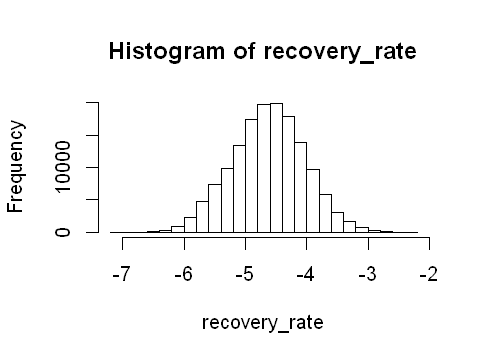

In [60]:
df_X <- df_loan[c('LoanId')]
df_X$Y <- 0
df_X$T <- factor(rep(1, nrow(df_X)), levels=levels(df_Y$T))
df_test <- merge(df_X, df_loan)
recovery_rate <- as.vector(predict(fit, df_test))
hist(recovery_rate)

The effect of different features can be interpreted from the coefficients:

In [61]:
coefs = summary(fit)$mat
coefs[61:nrow(coefs),]

,Coef,(95%,CI),SE,p
Year2010,0.76760489,0.553537613,0.981672171,0.10703364,7.411390e-13
Year2011,0.90241280,0.703324029,1.101501566,0.09954438,1.241120e-19
Year2012,0.82186483,0.652212385,0.991517282,0.08482622,3.364386e-22
Year2013,0.46596967,0.388504188,0.543435153,0.03873274,2.460202e-33
Year2014,0.26913172,0.200533895,0.337729540,0.03429891,4.272813e-15
Year2015,0.01068974,-0.059292531,0.080672014,0.03499114,7.599865e-01
Year2016,-0.14377181,-0.211582535,-0.075961086,0.03390536,2.231361e-05
Year2017,-0.06170149,-0.121237998,-0.002164987,0.02976825,3.819760e-02
Year2018,0.06516780,0.006046589,0.124289009,0.02956060,2.748577e-02
Year2020,0.25430394,-0.023265555,0.531873437,0.13878475,6.689746e-02


Lets again use the helper function to make some plots:

In [62]:
coef <- add_label(fit)
coef <- add_levels(df, coef)
coef.list <- split(coef, coef$Term)

It looks like 'Year' has a large effect on recoveries. The early loans have almost twice the recovery rate compared to loans in the past couple of years:

Warning message:
"Removed 1 rows containing missing values (geom_errorbar)."

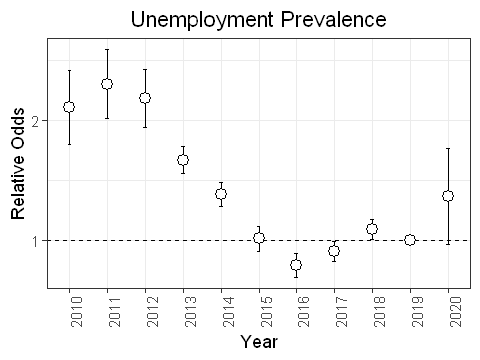

In [63]:
plot_oddsratio(coef.list[['Year']])

The 'Rating2' feature that combined 'Country':'Credit Rating' indicates that some countries (ES, FI, SK) have significantly lower recoveries, and there is a small effect of credit worthiness on the recoveries: 

Warning message:
"Removed 1 rows containing missing values (geom_errorbar)."

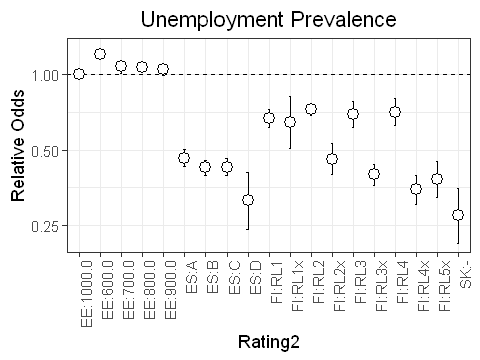

In [64]:
plot_oddsratio(coef.list[['Rating2']])

## Conclusion

R is an alternative programming language to implement the models. It has two main benefits: the models can be implemented without regularization (unbiased interpretation of coefficients) and the least squares regression can use a log-link (recovery rates are always positive).